# Ultimate Challenge - Login EDA

### Dependencies & Data

In [1]:
# Dependencies
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

# Settings
# pd.options.plotting.backend = 'plotly'
sns.set()
%matplotlib inline

In [2]:
# Login data
logins = pd.read_json('logins.json')
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


### Aggregate Logins into 15-minute Intervals

In [3]:
# Count logins in 15-minute internals
logins['Logins'] = 1
logins_15m = logins.set_index('login_time').resample('15min').count()
logins_15m['AvgLogins'] = logins_15m['Logins'].mean()
logins_15m.index.name = 'LoginTimeInterval'
logins_15m.head()

,Logins,AvgLogins
LoginTimeInterval,,
1970-01-01 20:00:00,2,9.515938
1970-01-01 20:15:00,6,9.515938
1970-01-01 20:30:00,9,9.515938
1970-01-01 20:45:00,7,9.515938
1970-01-01 21:00:00,1,9.515938


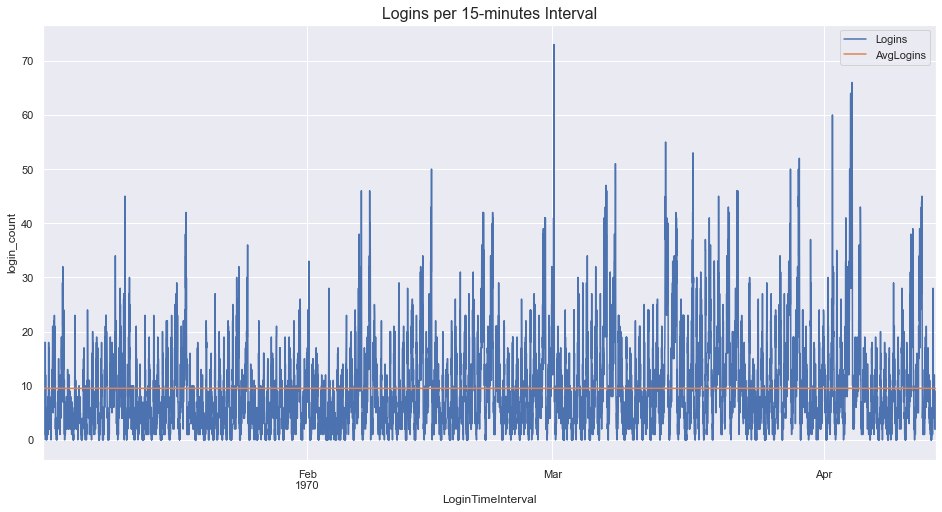

In [4]:
# # Plotly
# fig1 = logins_15m.plot(title='Logins per 15-minutes Interval', labels=dict(value='Count', variable='Variable'))
# fig1.show()

# Matplotlib
logins_15m.plot(figsize=(16, 8))
plt.title('Logins per 15-minutes Interval', fontsize=16)
plt.ylabel('login_count');

##### - Every 15 minutes, there are between 9 and 10 logins on average
##### - For the most part, the number of logins appears to oscillate below 30 logins (within 15-minute intervals)
##### - The highest number of logins in any 15-minute interval is a little over 70 logins

### Average Logins by Time of Day

In [5]:
# Extract time from timestamp
logins_15m['time'] = logins_15m.index.time
logins_15m.head()

,Logins,AvgLogins,time
LoginTimeInterval,,,
1970-01-01 20:00:00,2,9.515938,20:00:00
1970-01-01 20:15:00,6,9.515938,20:15:00
1970-01-01 20:30:00,9,9.515938,20:30:00
1970-01-01 20:45:00,7,9.515938,20:45:00
1970-01-01 21:00:00,1,9.515938,21:00:00


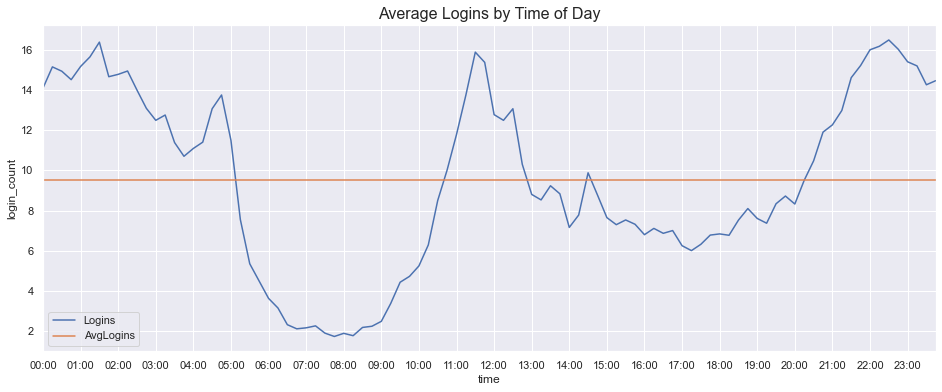

In [6]:
# Labels for xticks
idx = pd.date_range('00:00', '23:00', freq='h').time

# # Plotly
# fig2 = logins_15m.groupby('time').mean().plot(title='Average Logins by Time of Day', 
#                                        labels=dict(time='Time', value='Count', variable='Variable'))
# fig2.update_xaxes(tickvals=idx, tickangle=-45)
# fig2.show()

# Matplotlib
logins_15m.groupby('time').mean().plot(figsize=(16, 6), xticks=idx, xlim=(dt.time(0, 0), dt.time(23, 45)))
plt.title('Average Logins by Time of Day', fontsize=16)
plt.ylabel('login_count');

##### - Logins peak at around 1:30 AM, 11:30 AM, and 10:30 PM
##### - At 5 AM, the number logins drops dramatically, bottoming out around 8 AM, before increasing again to peak out at noon
##### - Logins dip below the average again between 1 PM and 8 PM
##### - Usage is the highest at noon and in the late night hours (between 9 PM and 5 AM) so efforts should be focused here
##### - There is very little usage between the hours of 6 AM and 10 AM

### Average Logins by Weekday and Time of Day

In [7]:
# Average logins by weekday and 15-minute interval
logins_15m['weekday'] = logins_15m.index.weekday
avg_weekly_logins = logins_15m.groupby(['weekday', 'time'], as_index=False).mean()

# Map weekday numbers to names
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
avg_weekly_logins['weekday'] = avg_weekly_logins['weekday'].map(dict(zip(range(7), weekdays)))

# Update time index
avg_weekly_logins['Time'] = avg_weekly_logins['weekday'] + ' ' + avg_weekly_logins['time'].astype(str).str.slice(0, 5)
avg_weekly_logins = avg_weekly_logins.set_index('Time').drop(['weekday', 'time'], axis=1)
avg_weekly_logins.head()

,Logins,AvgLogins
Time,,
Mon 00:00,8.400000,9.515938
Mon 00:15,9.333333,9.515938
Mon 00:30,9.600000,9.515938
Mon 00:45,8.066667,9.515938
Mon 01:00,7.266667,9.515938


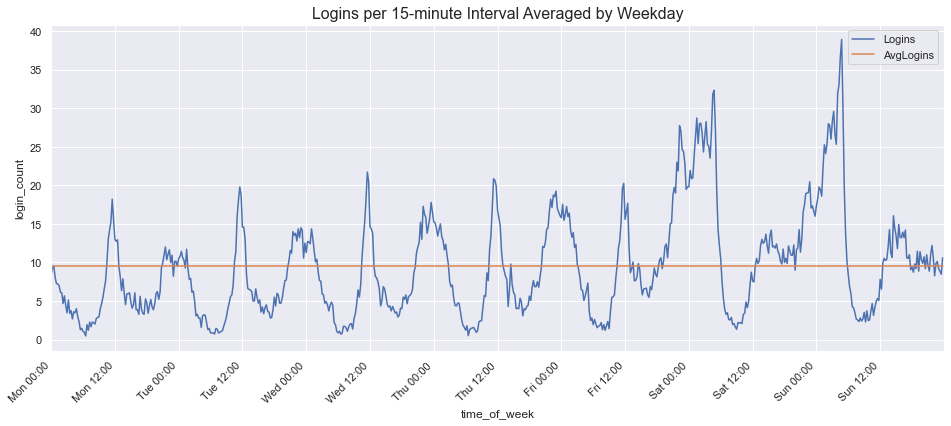

In [8]:
# Labels for xticks
ticks = range(0, avg_weekly_logins.shape[0], 48)
labels = [f'{weekdays[i//2]} 12:00' if i % 2 else f'{weekdays[i//2]} 00:00' for i in range(14)]

# # Plotly
# fig3 = avg_weekly_logins.plot(title='Logins per 15-minute Interval Averaged by Weekday', 
#                               labels=dict(value='Count', variable='Variable'))
# fig3.update_xaxes(tickvals=labels, tickangle=-45)
# fig3.show()

# Matplotlib
avg_weekly_logins.plot(figsize=(16, 6), xlim=(0, avg_weekly_logins.shape[0]))
plt.title('Logins per 15-minute Interval Averaged by Weekday', fontsize=16)
plt.ylabel('login_count')
plt.xlabel('time_of_week')
plt.xticks(ticks, labels, rotation=45, ha='right');

##### - The general pattern of peaking at noon and late night continues throughout the week
##### - Late night usage increases day by day, starting on Monday and maxing out on the weekends
##### - Logins during times of low usage remain relatively constant throughout the weekdays and has a small increase in the weekends
##### - Efforts should be focused on the weekends, especially during late night hours

### Aggregate Logins to Daily Intervals

In [9]:
# Average daily logins
logins_15m['DayOfYear'] = logins_15m.index.dayofyear
daily_logins = logins_15m.groupby('DayOfYear')[['Logins']].sum()
daily_logins['Avglogins'] = daily_logins['Logins'].mean()
daily_logins.head()

,Logins,Avglogins
DayOfYear,,
1,112,904.291262
2,681,904.291262
3,793,904.291262
4,788,904.291262
5,459,904.291262


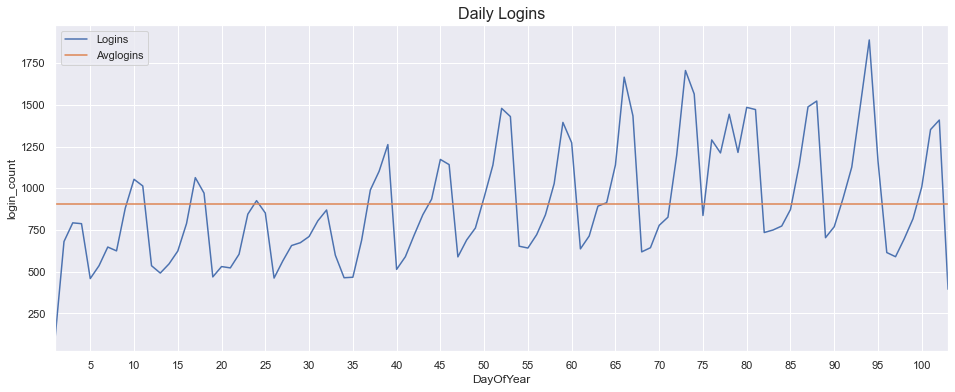

In [10]:
# Last day of year for xlimit
last_day = logins_15m['DayOfYear'].max()

# # Plotly
# fig4 = daily_logins.plot(title='Daily Logins', labels=dict(value='Count', variable='Variable'))
# fig4.update_xaxes(tickvals=list(range(0, last_day, 5)))
# fig4.show()

# Matplotlib
daily_logins.plot(figsize=(16, 6), xticks=range(0, last_day, 5), xlim=(1, last_day))
plt.title('Daily Logins', fontsize=16)
plt.ylabel('login_count');

##### - The average daily number of logins is 904 
##### - There is month-to-month growth in the number of logins
##### - Usage appears to dip during the week and peak every weekend

### Highlights:
##### - There are a lot more logins in the weekends than weekdays
##### - The most logins occur around noon (between 11 AM and 12 PM) and late at night (between 9 PM and 5 AM)
##### - There is very little activity in the morning between the hours of 6 AM and 10 AM